In [192]:
import pathlib
import time

import deepchem
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import compose, linear_model, metrics, model_selection
from sklearn import pipeline, preprocessing, utils

# MoleculeNet

One of the most powerful features of DeepChem is that it comes "batteries included" with datasets to use. The DeepChem developer community maintains the MoleculeNet [1] suite of datasets which maintains a large collection of different scientific datasets for use in machine learning applications. The original MoleculeNet suite had 17 datasets mostly focused on molecular properties. Over the last several years, MoleculeNet has evolved into a broader collection of scientific datasets to facilitate the broad use and development of scientific machine learning tools.

These datasets are integrated with the rest of the DeepChem suite so you can conveniently access these these through functions in the dc.molnet submodule. You've already seen a few examples of these loaders already as you've worked through the tutorial series. The full documentation for the MoleculeNet suite is available in our docs [2].

[1] Wu, Zhenqin, et al. "MoleculeNet: a benchmark for molecular machine learning." Chemical science 9.2 (2018): 513-530.

[2] https://deepchem.readthedocs.io/en/latest/moleculenet.html

https://pubs.acs.org/doi/pdf/10.1021/ci034243x

### Download and extract the data

In [19]:
DATA_DIR = pathlib.Path("../data/moleculenet/delaney")
DATA_DIR.mkdir(parents=True, exist_ok=True)

_, (dataset,), _ = (deepchem.molnet
                            .load_delaney(
                                data_dir=DATA_DIR,
                                reload=False,
                                save_dir=DATA_DIR,
                                splitter=None,
                                transformers=[],
                            )
                    )

### Load the data

We will load the data using the [Pandas](https://pandas.pydata.org/) library. Highly recommend the most recent edition of [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781491957653/) by Pandas creator Wes Mckinney for anyone interested in learning how to use Pandas.

In [3]:
%%bash

head ../data/moleculenet/delaney/delaney-processed.csv

Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
Amigdalin,-0.9740000000000001,1,457.4320000000001,7,3,7,202.31999999999996,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
Fenfuram,-2.885,1,201.22500000000002,1,2,2,42.24,-3.3,Cc1occc1C(=O)Nc2ccccc2
citral,-2.5789999999999997,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
Picene,-6.617999999999999,2,278.354,0,5,0,0.0,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
Thiophene,-2.2319999999999998,2,84.14299999999999,0,1,0,0.0,-1.33,c1ccsc1
benzothiazole,-2.733,2,135.191,0,2,0,12.89,-1.5,c2ccc1scnc1c2 
"2,2,4,6,6'-PCB",-6.545,1,326.437,0,2,1,0.0,-7.32,Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl
Estradiol,-4.138,1,272.388,2,4,0,40.46,-5.03,CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O
Dieldrin,-4.533,1,380.913,0,5,0,12.53,-6.29,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl


In [118]:
_usecols = [
    "Minimum Degree",
    "Molecular Weight",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
    "Polar Surface Area", 
    "measured log solubility in mols per litre",
    "smiles",
]

data = pd.read_csv(
    DATA_DIR / "delaney-processed.csv",
    usecols=_usecols,
)

### Explore the data

In [119]:
data.head()

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


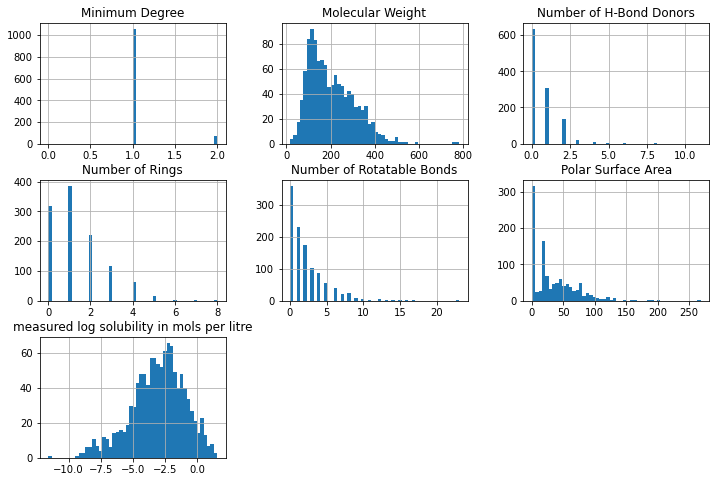

In [120]:
_ = data.hist(bins=50, figsize=(12, 8))

In [121]:
(data.corr()
     .loc[:, "measured log solubility in mols per litre"]
     .sort_values(ascending=False))

measured log solubility in mols per litre    1.000000
Number of H-Bond Donors                      0.209429
Polar Surface Area                           0.123210
Minimum Degree                              -0.130445
Number of Rotatable Bonds                   -0.244256
Number of Rings                             -0.512279
Molecular Weight                            -0.640189
Name: measured log solubility in mols per litre, dtype: float64

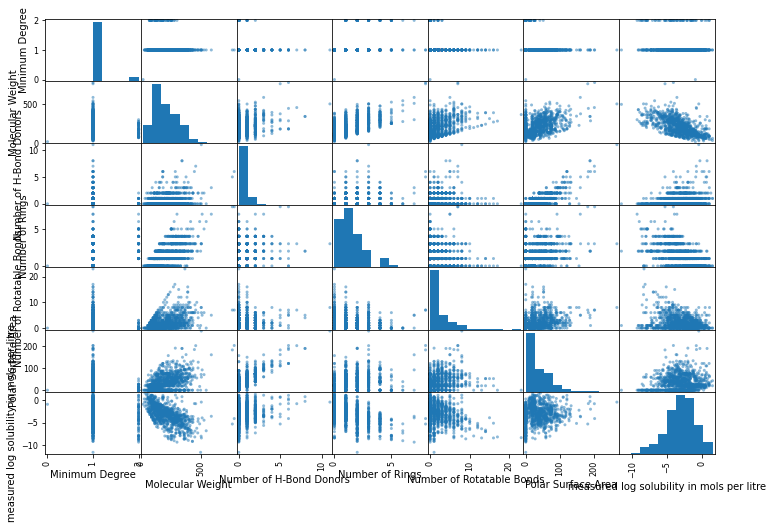

In [122]:
_ = (pd.plotting
       .scatter_matrix(data, figsize=(12, 8)))
plt.show()

In [123]:
cardinal_labels = [
    "Molecular Weight",
    "Polar Surface Area",
]
ordinal_labels = [
    "Minimum Degree",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
]
non_numeric_labels = [
    "smiles"
]

# split the features into three groups and extract the target
_target_label = "measured log solubility in mols per litre"
_dropped_labels = non_numeric_labels + ordinal_labels + [_target_label]
cardinal_features = data.drop(_dropped_labels, axis=1) 

_dropped_labels = non_numeric_labels + cardinal_labels + [_target_label]
ordinal_features = data.drop(_dropped_labels, axis=1)

_dropped_labels = cardinal_labels + ordinal_labels + [_target_label]
non_numeric_features = data.drop(_dropped_labels, axis=1)

target = data.loc[:, _target_label]

In [124]:
cardinal_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecular Weight    1128 non-null   float64
 1   Polar Surface Area  1128 non-null   float64
dtypes: float64(2)
memory usage: 17.8 KB


In [125]:
cardinal_features.head()

,Molecular Weight,Polar Surface Area
0,457.432,202.32
1,201.225,42.24
2,152.237,17.07
3,278.354,0.00
4,84.143,0.00


In [126]:
cardinal_features.describe()

,Molecular Weight,Polar Surface Area
count,1128.000000,1128.000000
mean,203.937074,34.872881
std,102.738077,35.383593
min,16.043000,0.000000
25%,121.183000,0.000000
50%,182.179000,26.300000
75%,270.372000,55.440000
max,780.949000,268.680000


In [127]:
ordinal_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Minimum Degree             1128 non-null   int64
 1   Number of H-Bond Donors    1128 non-null   int64
 2   Number of Rings            1128 non-null   int64
 3   Number of Rotatable Bonds  1128 non-null   int64
dtypes: int64(4)
memory usage: 35.4 KB


In [128]:
ordinal_features.head()

,Minimum Degree,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds
0,1,7,3,7
1,1,1,2,2
2,1,0,0,4
3,2,0,5,0
4,2,0,1,0


In [129]:
non_numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   smiles  1128 non-null   object
dtypes: object(1)
memory usage: 8.9+ KB


In [130]:
non_numeric_features.head()

,smiles
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Cc1occc1C(=O)Nc2ccccc2
2,CC(C)=CCCC(C)=CC(=O)
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,c1ccsc1


In [131]:
target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1128 entries, 0 to 1127
Series name: measured log solubility in mols per litre
Non-Null Count  Dtype  
--------------  -----  
1128 non-null   float64
dtypes: float64(1)
memory usage: 8.9 KB


In [132]:
target.describe()

count    1128.000000
mean       -3.050102
std         2.096441
min       -11.600000
25%        -4.317500
50%        -2.860000
75%        -1.600000
max         1.580000
Name: measured log solubility in mols per litre, dtype: float64

# Look at the Big Picture

Our goal over this three hands-on workshops will be to build a machine learning modeling pipeline that is capable of classifying images. Today we will mostly focus on classical machine learning algorithms implemented in Scikit-Learn; tomorrow we will revist the same problem using deep learning algorithms implemented in PyTorch. By the time you have finished this two-day workshop you should understand how to build a machine learning application capable of classifying images and be ready to apply what you have learned to a new dataset.

This morning we will mostly focus on getting the data and exploring the data to gain new insights. Believe it or not these initial steps are what data scientists and machine learning engineers spend the majority of their time doing! This afternoon we will prepare our data for machine learning, see how to fit a variety of machine learning models to our dataset and shortlist a few candidate models for further analysis. We will then use hyper-parameter tuning to improve the performance of our shortlisted models to arrive at an overall best model. We will finish with a discussion of how to present the results of your model and talk about some of the aspects of deploying a trained model to make predictions.

## Framing the problem

### What is the business/research objective?

Typically building the model is not the overall objective but rather the model itself is one part of a larger process used to answer a business/research question. Knowing the overall objective is important because it will determine your choice of machine learning algorithms to train, your measure(s) of model performance, and how much time you will spend tweaking the hyper-parameters of your model.

In our example today, the overall business/research objective is to build a tool for reading electricity meter serial numbers which consist of sequences of sometimes handwritten digits. Part of this tool will be a model that can correctly classify individual handwritten digits. Our image classication model is just one of potentially many other models whose predictions are taken as inputs into another machine learning model that will be used to read off the electricity meter serial numbers. 

### What is the current solution?

Always a good idea to know what the current solution to the problem you are trying to solve. Current solution gives a benchmark for performance. Note that the current "best" solution could be very simple or could be very sophisticated. Understanding the current solution helps you think of a good place to start. Example: suppose that the current solution for predicting the price of a house in a given census block is to ignore all the demographic information and predict a simple average of house prices in nearby census blocks. In this case it would probably not make sense to start building a complicated deep learning model to predict housing prices. However, if the current solution was a tuned gradient boosted machine then it probably would not make sense to try a much simpler linear regression model.

With all this information, you are now ready to start designing your system. First, you need to frame the problem by answering the following questions.

* Is our problem supervised, unsupervised, or reinforcement learning?
* Is our problem a classification task, a regression task, or something else? If our problem is a classification task are we trying to classify samples into 2 categories (binary classification) or more than 2 (multi-class classification) categories? If our problem is a regression task, are we trying to predict a single value (univariate regression) or multiple values (multivariate regression) for each sample?
* Should you use batch learning or online learning techniques?


### Exercise: Selecting a metric

Scikit-Learn has a number of different [possible metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) that you can choose from (or you can create your own custom metric if required). Can you find a few metrics that seems appropriate for our regression model?

# Creating a Test Dataset

Before we look at the data any further, we need to create a test set, put it aside, and never look at it (until we are ready to test our trainined machine learning model!). Why? We don't want our machine learning model to memorize our dataset (this is called overfitting). Instead we want a model that will generalize well (i.e., make good predictions) for inputs that it didn't see during training. To do this we hold split our dataset into training and testing datasets. The training dataset will be used to train our machine learning model(s) and the testing dataset will be used to make a final evaluation of our machine learning model(s).

## If you might refresh data in the future...

...then you want to use some particular hashing function to compute the hash of a unique identifier for each observation of data and include the observation in the test set if resulting hash value is less than some fixed percentage of the maximum possible hash value for your algorithm. This way even if you fetch more data, your test set will never include data that was previously included in the training data.

In [ ]:
import zlib


def in_testing_data(identifier, test_size):
    _hash = zlib.crc32(bytes(identifier))
    return _hash & 0xffffffff < test_size * 2**32


def split_train_test_by_id(data, test_size, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda identifier: in_testing_data(identifier, test_size))
    return data.loc[~in_test_set], data.loc[in_test_set]


## If this is all the data you will ever have...

...then you can just set a seed for the random number generator and then randomly split the data. Scikit-Learn has a [`model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) module that contains tools for splitting datasets into training and testing sets.

In [ ]:
model_selection.train_test_split?

In [133]:
SEED = 42
SEED_GENERATOR = np.random.RandomState(SEED)


def generate_seed():
    return SEED_GENERATOR.randint(np.iinfo("uint16").max)

In [160]:
# split the dataset into training and testing data
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)
train_features, test_features, train_target, test_target = model_selection.train_test_split(
    data.drop(_target, axis=1),
    #ordinal_features,
    #non_numeric_features,
    target,
    test_size=1e-1,
    random_state=_random_state
)

In [135]:
train_cardinal_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 795 to 289
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecular Weight    1015 non-null   float64
 1   Polar Surface Area  1015 non-null   float64
dtypes: float64(2)
memory usage: 23.8 KB


In [136]:
train_ordinal_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 795 to 289
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Minimum Degree             1015 non-null   int64
 1   Number of H-Bond Donors    1015 non-null   int64
 2   Number of Rings            1015 non-null   int64
 3   Number of Rotatable Bonds  1015 non-null   int64
dtypes: int64(4)
memory usage: 39.6 KB


In [137]:
train_non_numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 795 to 289
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   smiles  1015 non-null   object
dtypes: object(1)
memory usage: 15.9+ KB


In [138]:
train_target.info()

<class 'pandas.core.series.Series'>
Int64Index: 1015 entries, 795 to 289
Series name: measured log solubility in mols per litre
Non-Null Count  Dtype  
--------------  -----  
1015 non-null   float64
dtypes: float64(1)
memory usage: 15.9 KB


Again, if you want to you can write out the train and test sets to disk to avoid having to recreate them later.

In [ ]:
_ = (train_features.join(train_target)
                   .to_parquet(DATA_DIR / "train.parquet", index=False))

_ = (test_features.join(test_target)
                   .to_parquet(DATA_DIR / "test.parquet", index=False))

# Prepare the data for machine learning algorithms

Best practice is to write functions to automate the process of preparing your data for machine learning. Why?

* Allows you to reproduce these transformations easily on any dataset.
* You will gradually build a library of transformation functions that you can reuse in future projects.
* You can use these functions in a live system to transform the new data before feeding it to your algorithms.
* This will make it possible for you to easily experiment with various transformations and see which combination of transformations works best.

We are working with an benchmark dataset that has already been prepared for analysis (mostly!). You should be aware that academic benchmark datasets are not very representative of the type of datasets that you will encounter in most practical applications. 

## Feature Scaling

Machine learning algorithms typically don’t perform well when the input numerical attributes have very different scales. One of the most common approaches is to rescale features so that they all have zero mean and unit standard deviation. This approach, which is also called standardization, is particularly useful when attributes/features have outliers and when downstream machine learning algorithms assume that attributes/features have a Gaussian or Normal distribution. This approach is implemented in Scikit-Learn by the [`preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.StandardScaler) class.

In [35]:
preprocessing.StandardScaler?

Init signature: preprocessing.StandardScaler(*, copy=True, with_mean=True, with_std=True)
Docstring:     
Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample `x` is calculated as:

    z = (x - u) / s

where `u` is the mean of the training samples or zero if `with_mean=False`,
and `s` is the standard deviation of the training samples or one if
`with_std=False`.

Centering and scaling happen independently on each feature by computing
the relevant statistics on the samples in the training set. Mean and
standard deviation are then stored to be used on later data using
:meth:`transform`.

Standardization of a dataset is a common requirement for many
machine learning estimators: they might behave badly if the
individual features do not more or less look like standard normally
distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of
a learning algorithm (such as the RBF ke

In [139]:
# hyper-parameters
_hyperparameters = {
    "copy": True,
    "with_mean": True,
    "with_std": True,
}
preprocessor = preprocessing.StandardScaler(**_hyperparameters)

In [140]:
preprocessed_train_cardinal_features = preprocessor.fit_transform(train_cardinal_features)

In [141]:
preprocessed_train_cardinal_features.shape

(1015, 2)

In [142]:
preprocessed_train_cardinal_features[:, :5]

array([[ 0.4796579 , -0.27772776],
       [-0.47237914,  0.20267911],
       [-0.12827413, -0.27108619],
       ...,
       [-0.77095119, -0.99114304],
       [-1.16051203, -0.99114304],
       [-0.13779912, -0.99114304]])

In [143]:
preprocessed_train_cardinal_features.mean(axis=0)

array([ 2.11762737e-16, -2.27513684e-17])

In [144]:
preprocessed_train_cardinal_features.std(axis=0)

array([1., 1.])

The `preprocessing.MinMaxScaler` and the `preprocessing.StandardScaler` classes are the first Scikit-Learn `Transformer` classes that we have encountered. As such now is a good to to discuss the Scikit-Learn application programming interface (API). The [Scikit-Learn API](https://scikit-learn.org/stable/modules/classes.html) is one of the best designed API's around and has heavily influenced API design choices of other libraries in the Python Data Science and Machine Learning ecosystem, in particular [Dask](https://dask.org/) and [NVIDIA RAPIDS](https://rapids.ai/). Familiarly with the Scikit-Learn API will make it easier for you to get started with these libraries.

The Scikit-Learn API is built around the following key concepts.

* Estimators: Any object that can estimate some parameters based on a dataset is called an estimator (e.g., an `preprocessing.MinMaxScaler` is an estimator). The estimation itself is performed by the `fit` method, and it takes only a dataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter (such as the `feature_range` parameter in `preprocessing.MinMaxScaler`), and it must be set as an instance variable (generally via a constructor parameter).

* Transformers: Some estimators (such as an `preprocessing.MinMaxScaler`) can also transform a dataset; these are called transformers. Once again, the API is simple: the transformation is performed by the transform method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters. All transformers also have a convenience method called `fit_transform` that is equivalent to calling `fit` and then `transform` (but sometimes `fit_transform` is optimized and runs much faster).

* Predictors: Finally, some estimators, given a dataset, are capable of making predictions; they are called predictors. A predictor has a `predict` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a score method that measures the quality of the predictions, given a test set (and the corresponding labels, in the case of supervised learning algorithms).

All of an estimator’s hyperparameters are accessible directly via public instance variables (e.g., `preprocessor.feature_range`), and all the estimator’s learned parameters are accessible via public instance variables with an underscore suffix (e.g., `preprocessor.scale_`). Finally, Scikit-Learn provides reasonable default values for most parameters which makes it easy to quickly create a baseline working system.

### Exercise: MinMaxScaler vs StandardScaler

An alternative to standard scaling is to rescale features so that they all reside within the same range (typically between 0 and 1).

Create an instance of the [`preprocessing.MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) class and use it to rescale the training dataset. Compare the two different rescaled versions of the dataset. Which of the two methods do you prefer?

In [ ]:
# insert your code here!

As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

## Feature Engineering

Feature engineering is one of the most important parts of any machine learning project. There are two main tasks in feature engineering.

* Feature selection: selecting the best subset of features for training. 
* Feature extraction: combining existing features to produce new features for training.
* Feature creation: finding additional data sources to use as features.

Feature engineering is often the most labor intensive part of building a machine learning pipeline and often requires extensive expertise/domain knowledge relevant to the problem at hand. Recently packages such as [featuretools](https://www.featuretools.com/) have been developed to (partially) automate the process of feature engineering.

The success of deep learning in various domains is in significant part due to the fact that deep learning models are able to automatically engineer features that are most useful for solving certain machine learning tasks. In effect deep learning replaces the expensive to acquire expertise/domain knowledge required to hand-engineer predictive features. 

A recent example that demonstrates that power of automated feature engineering is [Space2vec](https://medium.com/dessa-news/space-2-vec-fd900f5566), a deep learning based supernovae classifier developed by machine learning engineers with no expertise in Astronomy that was able to outperform the machine learning solution developed by NERSC scientists. The machine learning pipeline developed by NERSC scientists, called [AUTOSCAN](https://portal.nersc.gov/project/dessn/autoscan/), was a significant improvement over the previous solution which relied on manual classification of supernovae by astronomers. However, in order to achieve such high accuracy, the NERSC solution relied on a dataset of hand-engineered features developed by astronomers with over a century of combined training and expertise in the domain. The deep learning algorithm used by space2vec could be applied directly to the raw image data and did not rely on any hand-engineered features.

In [177]:
deepchem.molnet.load_delaney?

Signature:
deepchem.molnet.load_delaney(
    featurizer: Union[deepchem.feat.base_classes.Featurizer, str] = 'ECFP',
    splitter: Union[deepchem.splits.splitters.Splitter, str, NoneType] = 'scaffold',
    transformers: List[Union[deepchem.molnet.load_function.molnet_loader.TransformerGenerator, str]] = ['normalization'],
    reload: bool = True,
    data_dir: Optional[str] = None,
    save_dir: Optional[str] = None,
    **kwargs,
) -> Tuple[List[str], Tuple[deepchem.data.datasets.Dataset, ...], List[transformers.Transformer]]
Docstring:
Load Delaney dataset

The Delaney (ESOL) dataset a regression dataset containing structures and
water solubility data for 1128 compounds. The dataset is widely used to
validate machine learning models on estimating solubility directly from
molecular structures (as encoded in SMILES strings).

Scaffold splitting is recommended for this dataset.

The raw data csv file contains columns below:

- "Compound ID" - Name of the compound
- "smiles" - SMILES rep

In [23]:
dataset.to_dataframe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1018,X1019,X1020,X1021,X1022,X1023,X1024,y,w,ids
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.770,1.0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.300,1.0,Cc1occc1C(=O)Nc2ccccc2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.060,1.0,CC(C)=CCCC(C)=CC(=O)
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.870,1.0,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.330,1.0,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.710,1.0,FC(F)(F)C(Cl)Br
1124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106,1.0,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-3.091,1.0,CCSCCSP(=S)(OC)OC
1126,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.180,1.0,CCC(C)C


## Transformation pipelines

As you can see creating preprocessing pipelines involves quite a lot of steps and each of the steps needs to be executed in the correct order. Fortunately Scikit-Learn allows you to combine estimators together to create [pipelines](https://scikit-learn.org/stable/modules/compose.html#combining-estimators). We can encapsulate all of the preprocessing logic into instances of the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class.

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform` method). The names can be anything you like (as long as they are unique). Later we will see how to access the parameters of pipelines using these names when we discuss hyperparameter tuning.

In [161]:
_seed = generate_seed()

_hyperparameters = {
    "copy": True,
    "with_mean": True,
    "with_std": True,
}

# default Pipeline constructor
cardinal_pipeline = pipeline.Pipeline(
    [
        ("standardscaler", preprocessing.StandardScaler(**_hyperparameters)),
    ],
    verbose=True,
)

_hyperparameters = {
    "feature_range": (0, 1),
    "copy": True,
    "clip": False,
}
ordinal_pipeline = pipeline.Pipeline(
    [
        ("minmaxscaler", preprocessing.MinMaxScaler(**_hyperparameters)),
    ],
    verbose=True,
)

_featurized_smiles = (dataset.to_dataframe()
                             .drop(['y', 'w', "ids"], axis=1))
_hyperparameters = {
    "func": lambda df: _featurized_smiles.loc[df.index, :],
}
non_numeric_pipeline = pipeline.Pipeline(
    [
        ("functiontransformer", preprocessing.FunctionTransformer(**_hyperparameters)),
    ],
    verbose=True,
)

In [168]:
_seed = generate_seed()

_hyperparameters = {
    "copy": True,
    "with_mean": True,
    "with_std": True,
}

# alternative constructor that is equivalent to the above!
cardinal_pipeline = pipeline.make_pipeline(
    preprocessing.StandardScaler(**_hyperparameters),
    verbose=True,
)

_hyperparameters = {
    "feature_range": (0, 1),
    "copy": True,
    "clip": False,
}

ordinal_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(**_hyperparameters),
    verbose=True,
)

_featurized_smiles = (dataset.to_dataframe()
                             .drop(['y', 'w', "ids"], axis=1))
_hyperparameters = {
    "func": lambda df: _featurized_smiles.loc[df.index, :],
}
non_numeric_pipeline = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(**_hyperparameters),
    verbose=True,
)

In [169]:
preprocessing_pipeline = compose.make_column_transformer(
    (cardinal_pipeline, compose.make_column_selector(dtype_include=np.float64)),
    (ordinal_pipeline, compose.make_column_selector(dtype_include=np.int64)),
    (non_numeric_pipeline, compose.make_column_selector(dtype_include=object)),
)

In [170]:
preprocessed_train_features = preprocessing_pipeline.fit_transform(train_features)

[Pipeline] .... (step 1 of 1) Processing standardscaler, total=   0.0s
[Pipeline] ...... (step 1 of 1) Processing minmaxscaler, total=   0.0s
[Pipeline]  (step 1 of 1) Processing functiontransformer, total=   0.0s


In [174]:
preprocessed_train_features.shape

(1015, 1030)

In [175]:
preprocessed_train_features[:5, :]

array([[ 0.52409186, -0.98102133,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18920228, -0.98102133,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18271142,  2.21172802,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28633043,  1.15134995,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.68030699, -0.98102133,  0.5       , ...,  0.        ,
         0.        ,  0.        ]])

# Select and train a model

At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for machine learning algorithms automatically. You are now ready to select and train a Machine Learning model. You might have been wondering if we were every going to make it to this point! Fact is, most of your time developing machine learning solutions to real-world problems will not be spent training machine learning models: most of your time will be spent preparing the data for machine learning algorithms and most of the computer time will be spent training the machine learning models.

## Training and evaluating on the training dataset

In [179]:
_seed = generate_seed()
_hyperparameters = {
    "fit_intercept": True,
    "loss": "squared_error",
    "penalty": None,
    "random_state": np.random.RandomState(_seed),
}
estimator = linear_model.SGDRegressor(**_hyperparameters)
_ = estimator.fit(preprocessed_train_features, train_target)

In [180]:
predictions = estimator.predict(preprocessed_train_features)

In [181]:
predictions

array([-7.32004618, -3.22664053, -2.35424693, ..., -5.07398549,
       -2.82143133, -2.8785643 ])

Congrats! You have fit your first machine learning model using Scikit-Learn and made some predictions. Now let's see how good those predictions really are.

### Evaluation metrics

#### Mean squared error

In [185]:
mse = metrics.mean_squared_error(
    train_target,
    predictions,
)
print(f"Root mean squared error: {np.sqrt(mse)}")

Root mean squared error: 0.6153542858131497


#### Mean absolute error

In [186]:
mae = metrics.mean_absolute_error(
    train_target,
    predictions,
)
print(f"Mean absolute squared error: {mae}")

Mean absolute squared error: 0.4644560667431664


#### Median absolute error

In [188]:
mae = metrics.median_absolute_error(
    train_target,
    predictions,
)
print(f"Median absolute squared error: {mae}")

Median absolute squared error: 0.3472745521555476


### Exercise: experiment with different loss functions

In [182]:
linear_model.SGDRegressor?

Init signature:
linear_model.SGDRegressor(
    loss='squared_error',
    *,
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=0,
    epsilon=0.1,
    random_state=None,
    learning_rate='invscaling',
    eta0=0.01,
    power_t=0.25,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    warm_start=False,
    average=False,
)
Docstring:     
Linear model fitted by minimizing a regularized empirical loss with SGD.

SGD stands for Stochastic Gradient Descent: the gradient of the loss is
estimated each sample at a time and the model is updated along the way with
a decreasing strength schedule (aka learning rate).

The regularizer is a penalty added to the loss function that shrinks model
parameters towards the zero vector using either the squared euclidean norm
L2 or the absolute norm L1 or a combination of both (Elastic Net). If the
parameter update crosses the 0.0 val

In [189]:
_seed = generate_seed()
_hyperparameters = {
    "fit_intercept": True,
    "loss": "squared_error", # change this!
    "penalty": None,
    "random_state": np.random.RandomState(_seed),
}
_estimator = linear_model.SGDRegressor(**_hyperparameters)
_ = _estimator.fit(preprocessed_train_features, train_target)

# make predictions
_predictions = _estimator.predict(preprocessed_train_features)

mse = metrics.mean_squared_error(
    train_target,
    _predictions,
)
print(f"Root mean squared error: {np.sqrt(mse)}")

Root mean squared error: 0.6267115931755081


### Exercise: experiment with different penalties

In [ ]:
linear_model.SGDRegressor?

In [190]:
_seed = generate_seed()
_hyperparameters = {
    "alpha": 1e-4, # try changing this!
    "fit_intercept": True,
    "l1_ratio": 0.15, # only used for penalty=elastic_net
    "loss": "squared_error",
    "penalty": None, # try changing this!
    "random_state": np.random.RandomState(_seed),
}
_estimator = linear_model.SGDRegressor(**_hyperparameters)
_ = _estimator.fit(preprocessed_train_features, train_target)

# make predictions
_predictions = _estimator.predict(preprocessed_train_features)

mse = metrics.mean_squared_error(
    train_target,
    _predictions,
)
print(f"Root mean squared error: {np.sqrt(mse)}")

Root mean squared error: 0.6309254088375759


### Mini-batch gradient descent

Since we talked about the difference between stochastic, batch, and mini-batch gradient descent in the lectures I wanted you to see how to implement mini-batch gradient descent in Scikit-Learn. You will see much more of this idea in the deep learning hands on session so we will not spend too much time on it now.

In [198]:
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)

n_epochs = 100
batch_size = 128
X = preprocessed_train_features
y = train_target
m, _ = X.shape

# define your estimator
_hyperparameters = {
    "alpha": 1e-4,
    "fit_intercept": True,
    "l1_ratio": 0.15,
    "learning_rate": "invscaling",
    "loss": "squared_error",
    "penalty": None,
    "random_state": _random_state,
    "warm_start": True,
}
estimator = linear_model.SGDRegressor(**_hyperparameters)

# nested for loops implement the training
for _ in range(n_epochs):

    # shuffle the dataset before every training epoch
    shuffled_indices = _random_state.permutation(m)
    _X, _y = X[shuffled_indices], y.iloc[shuffled_indices]

    for batch_ixs in utils.gen_batches(m, batch_size):
        _ = estimator.partial_fit(_X[batch_ixs], _y[batch_ixs])


In [199]:
# make predictions
_predictions = estimator.predict(preprocessed_train_features)

# report the error on the training set
mse = metrics.mean_squared_error(
    train_target,
    _predictions,
)
print(f"Root mean squared error: {np.sqrt(mse)}")

Root mean squared error: 0.5951126054800906


## Estimating generalization error using cross-validation

So far we have only evaluated our models performance on the training set. However, in order to assess whether we are overfitting or underfitting we need to estimate the generalization error.

The following code use Scikit-Learn [`model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) to randomly split the training set into distinct subsets called folds, then it trains and evaluates our model CV_FOLDS times, picking a different fold for evaluation every time and training on the other CV_FOLDS - 1 folds. The result is an array containing the CV_FOLDS evaluation scores.

In [218]:
CV_FOLDS = 5

estimator_scores = model_selection.cross_val_score(
    estimator,
    X=preprocessed_train_features,
    y=train_target,
    cv=CV_FOLDS,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


In [219]:
valid_error = -estimator_scores.mean()
print(f"Estimated generalization error: {valid_error}")

Estimated generalization error: 0.9369416322436575


What is going on here? Are we underfitting? Are we overfitting? If you think that we are underfitting, then what could we do to try and get the model to overfit? If we are overfitting, what could we do to get the model to underfit?

### Learning Curves

In [ ]:
model_selection.learning_curve?

In [207]:
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [220]:
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)
_hyperparameters = {
    "fit_intercept": True,
    "loss": "squared_error", # change this!
    "penalty": None,
    "random_state": np.random.RandomState(_seed),
}
_estimator = linear_model.SGDRegressor(**_hyperparameters)
_ = _estimator.fit(preprocessed_train_features, train_target)

train_sizes, train_scores, val_scores = model_selection.learning_curve(
    _estimator,
    preprocessed_train_features,
    train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    random_state=_random_state,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 15),
    verbose=1,
)

[learning_curve] Training set sizes: [ 81 133 185 237 290 342 394 446 498 551 603 655 707 759 812]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    4.7s finished


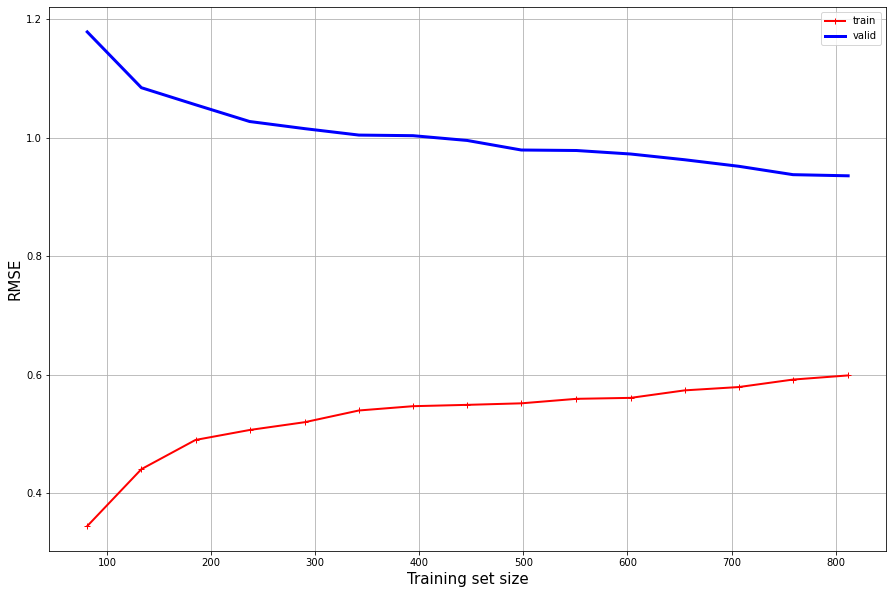

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(train_sizes, -train_scores.mean(axis=1), "r-+", linewidth=2, label="train")
ax.plot(train_sizes, -val_scores.mean(axis=1), "b-", linewidth=3, label="valid")
ax.set_xlabel("Training set size", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.grid()
ax.legend()

plt.show()

# Fine-tune your models

Most common approach to tuning a model is to manually fiddle with the hyperparameters until you find a great combination of hyperparameter values. Needless to day, this approach to model tuning is very tedious and not at all scientific. We can do much better!

## Grid Search

Simplest approach is to use Scikit-Learn’s [`model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out. The `model_selection.GridSearchCV` class will then use cross-validation to evaluate all the possible combinations of hyperparameter values and return the best scoring set of hyperparameters according to your specified metric.

In [ ]:
_seed = generate_seed()

_hyperparameters = {
    "copy": True,
    "with_mean": True,
    "with_std": True,
}

# alternative constructor that is equivalent to the above!
cardinal_pipeline = pipeline.make_pipeline(
    preprocessing.StandardScaler(**_hyperparameters),
    verbose=True,
)

_hyperparameters = {
    "feature_range": (0, 1),
    "copy": True,
    "clip": False,
}

ordinal_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(**_hyperparameters),
    verbose=True,
)

_featurized_smiles = (dataset.to_dataframe()
                             .drop(['y', 'w', "ids"], axis=1))
_hyperparameters = {
    "func": lambda df: _featurized_smiles.loc[df.index, :],
}
non_numeric_pipeline = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(**_hyperparameters),
    verbose=True,
)

_pipeline = compose.make_column_transformer(
    (cardinal_pipeline, compose.make_column_selector(dtype_include=np.float64)),
    (ordinal_pipeline, compose.make_column_selector(dtype_include=np.int64)),
    (non_numeric_pipeline, compose.make_column_selector(dtype_include=object)),
)

_parameter_grid = [
    {
        "pca__n_components": [25],
        "randomforestclassifier__max_depth": [None],
        "randomforestclassifier__max_features": [None],
        "randomforestclassifier__n_estimators": [2, 4, 8, 16],
        "randomforestclassifier__min_samples_leaf": [1],
        "randomforestclassifier__min_samples_split": [2]
    }, # 1 * 1 * 1 * 4 * 1 * 1 = 4 parameter combinations to try
    { # large number of short trees
        "randomforestclassifier__max_depth": [None],
        "randomforestclassifier__max_features": ["log2"],
        "randomforestclassifier__n_estimators": [100, 200, 400, 800],
        "randomforestclassifier__min_samples_leaf": [10, 100, 1000],
    } # 1 * 1 * 1 * 4 * 3 = 12 parameter combinations to try
] # 4 + 12 = 16 total parameter combinations to try

estimator = model_selection.GridSearchCV(
    _pipeline,
    _parameter_grid,
    cv=CV_FOLDS, # 3 * 16 = 48 total fits!
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
    pre_dispatch=2, # important to set this properly to avoid OOM errors
    verbose=1,
)

In [ ]:
_ = estimator.fit(preprocessed_train_features, train_target)

In [ ]:
estimator.best_score_

In [ ]:
estimator.best_params_

In [ ]:
estimator.best_estimator_

You should save every model you experiment with so that you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to more easily compare scores across model types and compare the types of errors they make.

In [ ]:
RESULTS_DIR = pathlib.Path("../results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(estimator, RESULTS_DIR / f"grid-search-cv-regressor-{timestamp}.pkl")

For reference here is how you would reload the trained model from the file.

In [ ]:
reloaded_estimator = joblib.load(RESULTS_DIR / f"grid-search-cv-regressor-{timestamp}.pkl")

In [ ]:
reloaded_estimator.best_params_

### Exercise:

Fine-tune one of your models using Grid Search.

In [ ]:
# insert your code here!

# Evaluate your models on the test dataset

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set.

In [216]:
# make predictions
Z = preprocessing_pipeline.transform(test_features)
predictions = estimator.predict(Z)

# report the error on the training set
mse = metrics.mean_squared_error(
    train_target,
    _predictions,
)
print(f"Root mean squared error: {np.sqrt(mse)}")

Root mean squared error: 0.5951126054800906


If you did a lot of hyperparameter tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.